# Classification-to-Segmentation: Class Activation Mapping for Zero-Shot Skin Lesion Segmentation

**Authors:** Matthew J. Cockayne, Marco Ortolani, and Baidaa Al-Bander  
**Published:** [International Conference on Artificial Intelligence in Healthcare (AIIH) 2025, University of Cambridge](https://doi.org/10.1007/978-3-032-00656-1_24)  
**GitHub:** [Classification-to-Segmentation](https://github.com/xraikeele/Classification-to-Segmentation)

---

## Demo Overview

This notebook demonstrates a **truly zero-shot segmentation pipeline** that:

1. Uses a **classification model with ImageNet pre-trained weights** (no domain-specific training)
2. Generates **Class Activation Maps (CAMs)** to localize discriminative regions from out-of-domain features
3. Samples **point prompts** from CAM peaks
4. Applies **MedSAM** (medical Segment Anything Model) for precise segmentation

**Key Advantage:** Complete zero-shot approach - no pixel-level segmentation masks AND no in-domain classification training required.

> **⚠️ Note:** This demo uses **ImageNet pre-trained weights only** to demonstrate the zero-shot capability. The published paper uses models fine-tuned on melanoma classification for improved performance. This demo shows the method works even without domain-specific training.

---

## Table of Contents

1. [Setup & Imports](#setup)
2. [Data Loading](#data)
3. [Model Architecture](#models)
4. [CAM Generation](#cam)
5. [Point Sampling Strategy](#points)
6. [MedSAM Segmentation](#medsam)
7. [Results & Evaluation](#results)
8. [Interactive Demo](#interactive)

---
## 1. Setup & Imports {#setup}

In [1]:
# Standard libraries
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Scientific computing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Computer vision
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Deep learning
import torch
import torch.nn as nn
from torchvision import transforms

# CAM methods
from pytorch_grad_cam import (
    GradCAM, GradCAMPlusPlus, EigenGradCAM, 
    AblationCAM, RandomCAM
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.ablation_layer import AblationLayerVit

# SAM
from segment_anything import sam_model_registry, SamPredictor

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Custom modules
from models.load_models import load_model
from data.dataloader import get_dataloaders

print("All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All imports successful
PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


### Configuration

In [2]:
# Paths
DEMO_DATA_DIR = "./demo_data"  # Demo samples directory
CHECKPOINT_DIR = "../model_checkpoints/"  # Model checkpoints directory
MEDSAM_CHECKPOINT = os.path.join(CHECKPOINT_DIR, "medsam_vit_b.pth")

# Model selection (change this to try different models)
MODEL_NAME = "mobilenet_v2"  # Options: resnet50, mobilenet_v2, efficientnet_b0, ViT, swin
MODEL_TYPE = "CNN"  # CNN for resnet/mobilenet/efficientnet, ViT for ViT, swin for swin

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Configuration:")
print(f"   Model: {MODEL_NAME}")
print(f"   Device: {DEVICE}")
print(f"   Demo data: {os.path.exists(DEMO_DATA_DIR)}")
print(f"   MedSAM checkpoint: {os.path.exists(MEDSAM_CHECKPOINT)}")

Configuration:
   Model: mobilenet_v2
   Device: cuda
   Demo data: True
   MedSAM checkpoint: True


In [3]:
def set_seed(seed=905):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(905)

Random seed set to 905


---
## 2. Data Loading {#data}

We'll use the **ISIC 2017** dataset:
- **Training:** 2000 dermoscopic images
- **Validation:** 150 images
- **Test:** 600 images
- **Task:** Binary classification (melanoma vs. benign)
- **Ground Truth:** Segmentation masks available for evaluation

In [4]:
# Load demo samples
print("Loading demo samples...")
demo_info = pd.read_csv(os.path.join(DEMO_DATA_DIR, "demo_info.csv"))

# Fix paths - remove 'notebooks/' prefix since we're already in notebooks directory
demo_info['image_path'] = demo_info['image_path'].str.replace('notebooks/', '', regex=False)
demo_info['mask_path'] = demo_info['mask_path'].str.replace('notebooks/', '', regex=False)

print(f"Demo dataset loaded:")
print(f"   Number of samples: {len(demo_info)}")
print(f"   Melanoma cases: {sum(demo_info['label'] == 'Melanoma')}")
print(f"   Benign cases: {sum(demo_info['label'] == 'Benign')}")
print("\nSample descriptions:")
for idx, row in demo_info.iterrows():
    print(f"   {idx+1}. {row['image_id']}: {row['description']}")

Loading demo samples...
Demo dataset loaded:
   Number of samples: 5
   Melanoma cases: 0
   Benign cases: 5

Sample descriptions:
   1. ISIC_0012223: Benign, large lesion, compact/circular
   2. ISIC_0014941: Benign, large lesion, irregular shape
   3. ISIC_0015273: Benign, small lesion, irregular shape
   4. ISIC_0016066: Benign, small lesion, compact/circular
   5. ISIC_0016070: Benign, small lesion, moderate shape


---
## 3. Model Architecture {#models}

We'll load a pre-trained classification model. These models were trained on **image-level labels only** (no segmentation masks).

### Supported Models:
- **ResNet50** - Deep residual network (23M params)
- **MobileNetV2** - Lightweight mobile architecture (2.2M params)
- **EfficientNet-B0** - Efficient compound scaling (4M params)
- **ViT** (Vision Transformer) - Attention-based architecture (86M params)
- **Swin Transformer** - Hierarchical vision transformer (47M params)

In [5]:
def layer_selection(model, model_name):
    """Select target layer for CAM extraction based on model architecture."""
    if model_name == "resnet50":
        return [model.layer4[-1]]
    elif model_name == "mobilenet_v2":
        return [model.features[-1]]
    elif model_name == "efficientnet_b0":
        return [model.features[-1]]
    elif model_name == "ViT":
        return [model.encoder.layers[-1].ln_1]
    elif model_name == "swin":
        return [model.features[-1][1].norm1]
    else:
        raise NotImplementedError(f"Layer selection not implemented for: {model_name}")

# Load classification model
print(f"Loading {MODEL_NAME}...")
model = load_model(MODEL_NAME, num_classes=1)

# Load trained checkpoint (if available)
checkpoint_path = f"../results/classification/{MODEL_NAME}/{MODEL_NAME}_best_model.pth"
if os.path.exists(checkpoint_path):
    print(f"   Loading checkpoint from {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
else:
    print(f"   ⚠️ Checkpoint not found. Using ImageNet pre-trained weights.")

model.to(DEVICE)
model.eval()

# Get target layer for CAM
target_layers = layer_selection(model, MODEL_NAME)

print(f"Model loaded successfully")
print(f"   Target layer for CAM: {target_layers[0].__class__.__name__}")

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

Loading mobilenet_v2...
   ⚠️ Checkpoint not found. Using ImageNet pre-trained weights.
Model loaded successfully
   Target layer for CAM: Conv2dNormActivation
   Total parameters: 2,225,153
   Trainable parameters: 2,225,153


### Visualize Sample Data

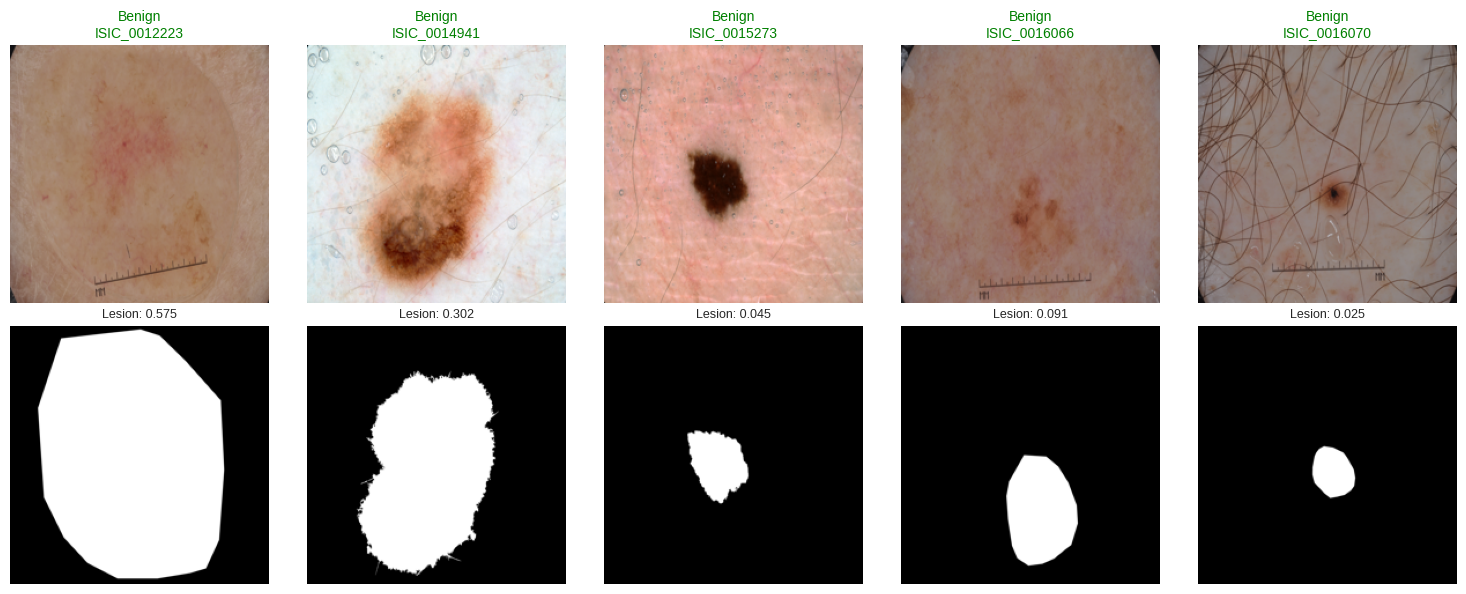

In [6]:
def visualize_demo_samples(demo_info):
    """Visualize all demo samples with images and masks."""
    num_samples = len(demo_info)
    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
    
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, row in demo_info.iterrows():
        # Load image and mask
        img = Image.open(row['image_path']).convert("RGB")
        mask = Image.open(row['mask_path']).convert("L")
        
        # Resize for display
        img_resized = img.resize((224, 224))
        mask_resized = mask.resize((224, 224))
        
        # Plot image
        axes[0, idx].imshow(img_resized)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f"{row['label']}\n{row['image_id']}", 
                               fontsize=10, color='red' if row['label'] == 'Melanoma' else 'green')
        
        # Plot mask
        axes[1, idx].imshow(mask_resized, cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f"Lesion: {row['lesion_ratio']}", fontsize=9)
    
    axes[0, 0].set_ylabel('Images', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_demo_samples(demo_info)

---
## 4. CAM Generation {#cam}

**Class Activation Mapping (CAM)** highlights the regions in an image that the model focuses on for classification.

### How CAM Works:

1. **Forward pass** through the classification model
2. **Extract** feature maps from the last convolutional layer
3. **Compute gradients** of the predicted class w.r.t. feature maps
4. **Weight** feature maps by gradient importance
5. **Sum** weighted feature maps to create heatmap

### CAM Methods:
- **GradCAM** - Gradient-weighted activation maps
- **GradCAM++** - Improved localization with weighted gradients
- **EigenCAM** - Principal component analysis of activations

In [7]:
def reshape_transform_vit(tensor, height=14, width=14):
    """Reshape transform for Vision Transformer."""
    result = tensor[:, 1:, :].reshape(
        tensor.size(0), height, width, tensor.size(2)
    )
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def reshape_transform_swin(tensor):
    """Reshape transform for Swin Transformer."""
    if len(tensor.shape) == 4:
        batch_size, height, width, num_features = tensor.size()
        return tensor.permute(0, 3, 1, 2)
    elif len(tensor.shape) == 3:
        batch_size, num_patches, num_features = tensor.size()
        height = width = int(num_patches**0.5)
        return tensor.view(batch_size, height, width, num_features).permute(0, 3, 1, 2)
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

# Initialize CAM methods
if MODEL_TYPE == "ViT":
    cam_methods = {
        "GradCAM": GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform_vit),
        "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform_vit),
        "EigenCAM": EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform_vit),
    }
elif MODEL_TYPE == "swin":
    cam_methods = {
        "GradCAM": GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform_swin),
        "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform_swin),
        "EigenCAM": EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform_swin),
    }
else:  # CNN
    cam_methods = {
        "GradCAM": GradCAM(model=model, target_layers=target_layers),
        "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layers),
        "EigenCAM": EigenGradCAM(model=model, target_layers=target_layers),
    }

print(f"Initialized {len(cam_methods)} CAM methods:")
for method_name in cam_methods.keys():
    print(f"   - {method_name}")

Initialized 3 CAM methods:
   - GradCAM
   - GradCAM++
   - EigenCAM


In [8]:
def process_image_with_cam(image_path, model, cam_extractor, device):
    """Generate CAM heatmap for an image."""
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    
    predicted_class = (torch.sigmoid(output) > 0.5).item()
    confidence = torch.sigmoid(output).item()
    
    # Generate CAM
    activation_map = cam_extractor(
        input_tensor, 
        targets=[ClassifierOutputTarget(0)]  # Binary classification
    )
    
    heatmap = activation_map[0]
    heatmap = np.clip(heatmap, 0, None)
    
    # Normalize heatmap
    if heatmap.max() > heatmap.min():
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Resize to original image size
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
    
    return heatmap_resized, img, predicted_class, confidence

# Test CAM generation on first demo sample
sample_image = demo_info.iloc[0]['image_path']
print(f"Testing CAM generation on: {demo_info.iloc[0]['image_id']}")
print(f"Description: {demo_info.iloc[0]['description']}")

Testing CAM generation on: ISIC_0012223
Description: Benign, large lesion, compact/circular


### Compare Different CAM Methods

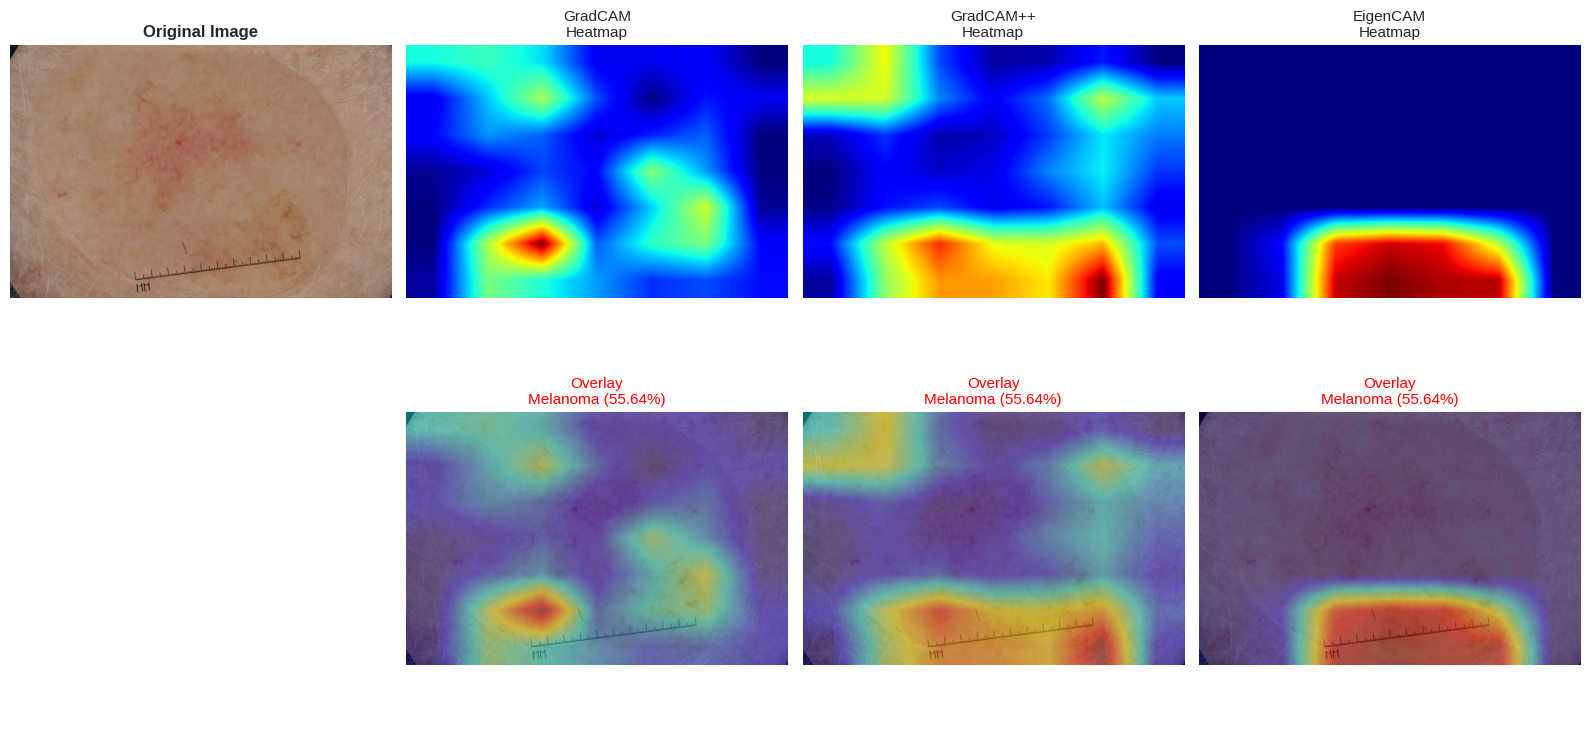

In [9]:
def visualize_cam_comparison(image_path, model, cam_methods, device):
    """Visualize different CAM methods side-by-side."""
    num_methods = len(cam_methods)
    fig, axes = plt.subplots(2, num_methods + 1, figsize=(4 * (num_methods + 1), 8))
    
    # Load original image
    original_img = Image.open(image_path).convert("RGB")
    
    # Show original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Process with each CAM method
    for idx, (method_name, cam_extractor) in enumerate(cam_methods.items(), 1):
        heatmap, img, pred_class, confidence = process_image_with_cam(
            image_path, model, cam_extractor, device
        )
        
        # Show heatmap
        im1 = axes[0, idx].imshow(heatmap, cmap='jet')
        axes[0, idx].set_title(f'{method_name}\nHeatmap', fontsize=11)
        axes[0, idx].axis('off')
        
        # Show overlay
        img_array = np.array(img)
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(img_array, 0.6, heatmap_colored, 0.4, 0)
        
        axes[1, idx].imshow(overlay)
        axes[1, idx].set_title(f'Overlay\n{"Melanoma" if pred_class else "Benign"} ({confidence:.2%})', 
                               fontsize=11, color='red' if pred_class else 'green')
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize comparison
visualize_cam_comparison(sample_image, model, cam_methods, DEVICE)

---
## 5. Point Sampling Strategy {#points}

We convert the CAM heatmap into **point prompts** for SAM by:

1. **Amplifying** high-confidence regions using power law ($\text{weight}^{30}$)
2. **Probabilistic sampling** weighted by CAM values
3. **Extracting** N points (default: 10) as $(x, y)$ coordinates

This ensures points are concentrated in regions the classifier considers most important.

Random seed set to 905


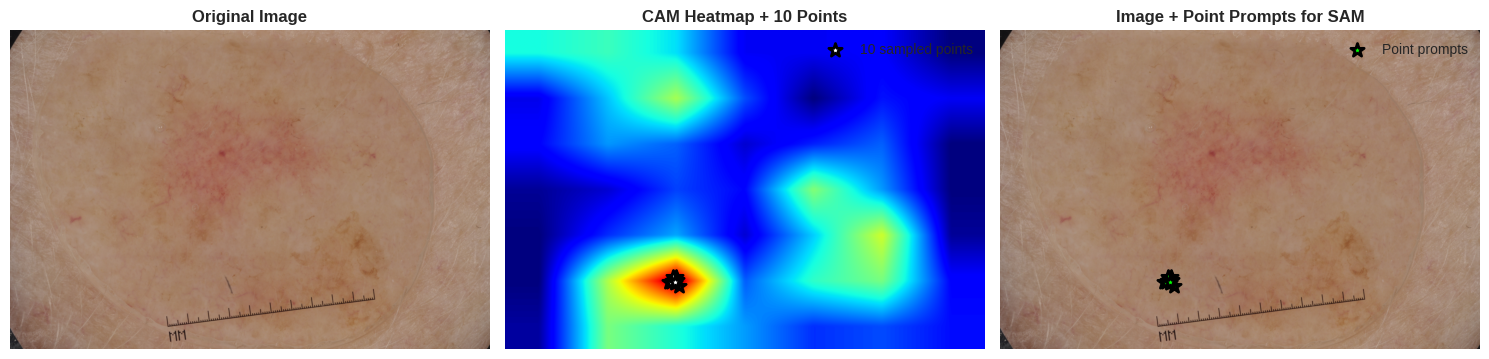

In [10]:
def sample_points(heatmap, num_points=10, power=30):
    """
    Sample points from heatmap using weighted probabilistic sampling.
    
    Args:
        heatmap: 2D numpy array of CAM values
        num_points: Number of points to sample
        power: Exponent for amplifying high values (default: 30)
    
    Returns:
        Array of (x, y) coordinates
    """
    height, width = heatmap.shape
    flat_heatmap = heatmap.flatten()
    
    # Amplify high values
    flat_heatmap = np.power(flat_heatmap, power)
    
    # Handle edge cases
    if flat_heatmap.sum() == 0 or np.isnan(flat_heatmap).any():
        print("Warning: Invalid heatmap, returning random points")
        return np.random.randint(0, width, size=(num_points, 2))
    
    # Normalize to probabilities
    probabilities = flat_heatmap / flat_heatmap.sum()
    
    # Sample indices
    indices = np.arange(len(flat_heatmap))
    sampled_indices = np.random.choice(
        indices, 
        size=num_points, 
        replace=False, 
        p=probabilities
    )
    
    # Convert to 2D coordinates
    sampled_coords = [(idx % width, idx // width) for idx in sampled_indices]
    
    return np.array(sampled_coords)

# Visualize point sampling
def visualize_point_sampling(image_path, heatmap, num_points=10):
    """Visualize sampled points on image and heatmap."""
    set_seed(905)  # For consistent visualization
    
    img = Image.open(image_path).convert("RGB")
    points = sample_points(heatmap, num_points=num_points)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Heatmap with points
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].scatter(points[:, 0], points[:, 1], c='white', s=100, marker='*', 
                   edgecolors='black', linewidths=2, label=f'{num_points} sampled points')
    axes[1].set_title(f'CAM Heatmap + {num_points} Points', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].axis('off')
    
    # Image with points
    img_array = np.array(img)
    axes[2].imshow(img_array)
    axes[2].scatter(points[:, 0], points[:, 1], c='lime', s=100, marker='*',
                   edgecolors='black', linewidths=2, label='Point prompts')
    axes[2].set_title('Image + Point Prompts for SAM', fontsize=12, fontweight='bold')
    axes[2].legend(loc='upper right')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get heatmap for visualization
heatmap_demo, img_demo, _, _ = process_image_with_cam(
    sample_image, model, cam_methods["GradCAM"], DEVICE
)
visualize_point_sampling(sample_image, heatmap_demo, num_points=10)

---
## 6. MedSAM Segmentation {#medsam}

**MedSAM** is a medical-domain fine-tuned version of Meta's Segment Anything Model (SAM).

### Pipeline:
1. Load MedSAM model (ViT-B backbone)
2. Set input image
3. Provide point prompts from CAM
4. Generate segmentation mask
5. Post-process with morphological operations

In [11]:
# Load MedSAM
print(f"Loading MedSAM from {MEDSAM_CHECKPOINT}...")
sam = sam_model_registry['vit_b'](checkpoint=MEDSAM_CHECKPOINT)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

print("MedSAM loaded successfully")
print(f"   Model: vit_b")
print(f"   Parameters: ~91M")

Loading MedSAM from ../model_checkpoints/medsam_vit_b.pth...
MedSAM loaded successfully
   Model: vit_b
   Parameters: ~91M
MedSAM loaded successfully
   Model: vit_b
   Parameters: ~91M


In [12]:
def post_process_mask(mask):
    """Apply morphological operations to clean up mask."""
    mask = (mask * 255).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Fill small holes
    return mask / 255.0  # Normalize back to [0, 1]

def generate_bounding_box_from_heatmap(heatmap, threshold=0.5):
    """
    Generate a bounding box from CAM heatmap.
    
    Args:
        heatmap: 2D numpy array of CAM values
        threshold: Threshold for considering pixels (default: 0.5)
    
    Returns:
        box: Bounding box as [x_min, y_min, x_max, y_max]
    """
    # Threshold the heatmap to get regions of interest
    binary_map = (heatmap > threshold).astype(np.uint8)
    
    # Find coordinates of all positive pixels
    y_indices, x_indices = np.where(binary_map > 0)
    
    if len(x_indices) == 0 or len(y_indices) == 0:
        print("Warning: No significant region found in heatmap, using full image bounds")
        return np.array([0, 0, heatmap.shape[1], heatmap.shape[0]])
    
    # Get bounding box coordinates
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    
    # Add some padding (10% on each side)
    padding_x = int((x_max - x_min) * 0.1)
    padding_y = int((y_max - y_min) * 0.1)
    
    x_min = max(0, x_min - padding_x)
    x_max = min(heatmap.shape[1], x_max + padding_x)
    y_min = max(0, y_min - padding_y)
    y_max = min(heatmap.shape[0], y_max + padding_y)
    
    return np.array([x_min, y_min, x_max, y_max])

def segment_with_medsam(image_path, heatmap, predictor, num_points=10, ground_truth=None):
    """
    Segment image using MedSAM with CAM-guided bounding box and point prompts.
    
    This implements the full MedSAM approach with:
    1. Bounding box generation from CAM heatmap
    2. Point prompt sampling from high-confidence regions
    3. Multiple mask generation with perturbations
    4. Best mask selection based on confidence or IoU
    
    Args:
        image_path: Path to input image
        heatmap: CAM heatmap (same size as image)
        predictor: MedSAM predictor
        num_points: Number of point prompts to sample
        ground_truth: Optional ground truth mask for IoU-based selection
    
    Returns:
        predicted_mask: Binary segmentation mask
        sampled_points: (x, y) coordinates of point prompts
        bounding_box: Bounding box [x_min, y_min, x_max, y_max]
        best_score: Confidence score or IoU of best mask
    """
    # Load and prepare image
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img)
    original_h, original_w = img_array.shape[:2]
    
    # Resize image to 1024x1024 (MedSAM's native resolution)
    img_1024 = cv2.resize(img_array, (1024, 1024))
    
    # Set image in predictor
    predictor.set_image(img_1024)
    
    # Generate bounding box from heatmap
    set_seed(905)
    bbox = generate_bounding_box_from_heatmap(heatmap, threshold=0.5)
    
    # Scale bounding box to 1024x1024
    scale_x = 1024 / original_w
    scale_y = 1024 / original_h
    bbox_1024 = bbox.copy()
    bbox_1024[0] = int(bbox[0] * scale_x)  # x_min
    bbox_1024[1] = int(bbox[1] * scale_y)  # y_min
    bbox_1024[2] = int(bbox[2] * scale_x)  # x_max
    bbox_1024[3] = int(bbox[3] * scale_y)  # y_max
    
    # Sample points from CAM (in original resolution)
    sampled_points_orig = sample_points(heatmap, num_points=num_points)
    
    # Scale points to 1024x1024
    sampled_points_1024 = sampled_points_orig.copy().astype(float)
    sampled_points_1024[:, 0] = sampled_points_orig[:, 0] * scale_x
    sampled_points_1024[:, 1] = sampled_points_orig[:, 1] * scale_y
    
    input_labels = np.ones(num_points)  # All positive prompts
    
    # Generate multiple masks with different strategies
    all_masks = []
    all_scores = []
    
    # Strategy 1: Box + Points
    masks, scores, _ = predictor.predict(
        point_coords=sampled_points_1024,
        point_labels=input_labels,
        box=bbox_1024[None, :],  # Add batch dimension
        multimask_output=True
    )
    all_masks.extend(masks)
    all_scores.extend(scores)
    
    # Strategy 2: Box only (for comparison)
    masks_box, scores_box, _ = predictor.predict(
        box=bbox_1024[None, :],
        multimask_output=True
    )
    all_masks.extend(masks_box)
    all_scores.extend(scores_box)
    
    # Strategy 3: Points only (for comparison)
    masks_points, scores_points, _ = predictor.predict(
        point_coords=sampled_points_1024,
        point_labels=input_labels,
        multimask_output=True
    )
    all_masks.extend(masks_points)
    all_scores.extend(scores_points)
    
    # Select best mask
    if ground_truth is not None:
        # Select based on IoU with ground truth
        gt_resized = cv2.resize(ground_truth, (1024, 1024))
        gt_binary = (gt_resized > 0.5).astype(np.uint8)
        
        best_iou = 0
        best_mask_idx = 0
        for idx, mask in enumerate(all_masks):
            mask_binary = mask.astype(np.uint8)
            intersection = np.sum((mask_binary == 1) & (gt_binary == 1))
            union = np.sum((mask_binary == 1) | (gt_binary == 1))
            iou = intersection / union if union > 0 else 0
            
            if iou > best_iou:
                best_iou = iou
                best_mask_idx = idx
        
        best_score = best_iou
    else:
        # Select based on confidence score
        best_mask_idx = np.argmax(all_scores)
        best_score = all_scores[best_mask_idx]
    
    predicted_mask = all_masks[best_mask_idx]
    
    # Resize mask back to original image size
    predicted_mask = cv2.resize(predicted_mask.astype(np.uint8), (original_w, original_h))
    
    # Post-process
    predicted_mask = post_process_mask(predicted_mask)
    
    return predicted_mask, sampled_points_orig, bbox, best_score

# Demo segmentation
print("Running MedSAM segmentation with bounding box + points...")
mask_pred, points_used, bbox_used, score = segment_with_medsam(
    sample_image, heatmap_demo, predictor, num_points=10
)
print(f"Segmentation complete (score: {score:.3f})")
print(f"Bounding box: [{bbox_used[0]:.0f}, {bbox_used[1]:.0f}, {bbox_used[2]:.0f}, {bbox_used[3]:.0f}]")

Running MedSAM segmentation with bounding box + points...
Random seed set to 905
Random seed set to 905
Segmentation complete (score: 0.654)
Bounding box: [590, 303, 3736, 2825]
Segmentation complete (score: 0.654)
Bounding box: [590, 303, 3736, 2825]


### Visualize Complete Pipeline

Random seed set to 905


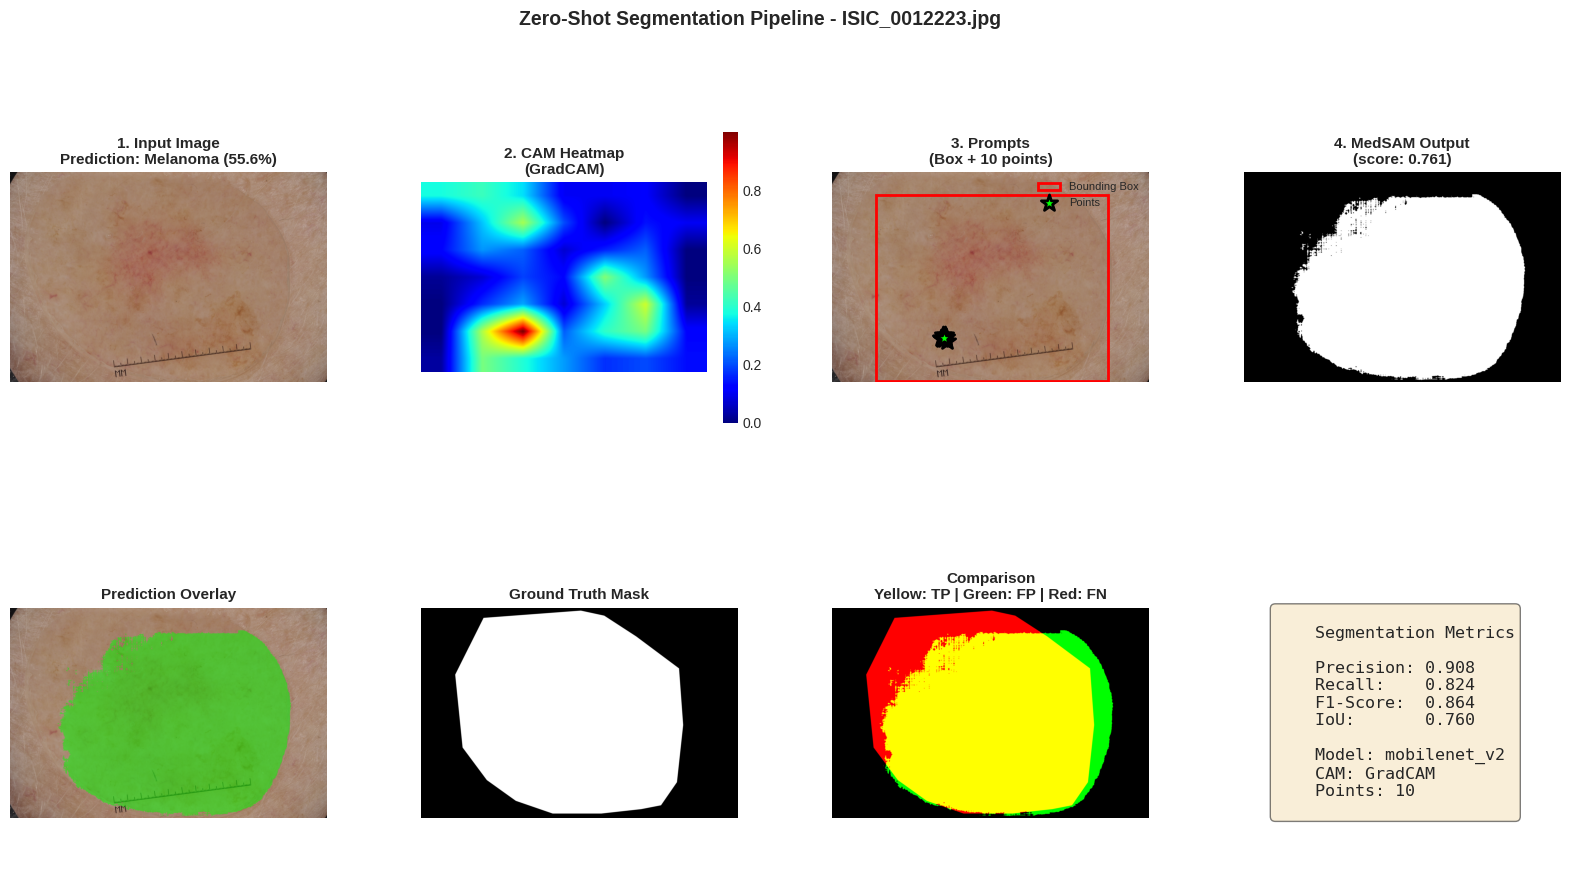

In [13]:
def visualize_full_pipeline(image_path, mask_path, model, cam_extractor, predictor, device, num_points=10):
    """Visualize complete zero-shot segmentation pipeline."""
    # Generate CAM
    heatmap, img, pred_class, confidence = process_image_with_cam(
        image_path, model, cam_extractor, device
    )
    
    # Load ground truth
    gt_mask = np.array(Image.open(mask_path).convert("L")) / 255.0
    
    # Segment with MedSAM (now returns 4 values: mask, points, bbox, score)
    predicted_mask, sampled_points, bbox, sam_score = segment_with_medsam(
        image_path, heatmap, predictor, num_points=num_points, ground_truth=gt_mask
    )
    
    # Create visualization
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    img_array = np.array(img)
    
    # Row 1: Pipeline stages
    # Original image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_array)
    ax1.set_title(f'1. Input Image\nPrediction: {"Melanoma" if pred_class else "Benign"} ({confidence:.1%})',
                 fontsize=11, fontweight='bold')
    ax1.axis('off')
    
    # CAM heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    im = ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('2. CAM Heatmap\n(GradCAM)', fontsize=11, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046)
    
    # Points + Bounding box on image
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(img_array)
    # Draw bounding box
    rect = mpatches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                               linewidth=2, edgecolor='red', facecolor='none', label='Bounding Box')
    ax3.add_patch(rect)
    # Draw points
    ax3.scatter(sampled_points[:, 0], sampled_points[:, 1], 
               c='lime', s=150, marker='*', edgecolors='black', linewidths=2, label='Points')
    ax3.set_title(f'3. Prompts\n(Box + {num_points} points)', fontsize=11, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.axis('off')
    
    # MedSAM prediction
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(predicted_mask, cmap='gray')
    ax4.set_title(f'4. MedSAM Output\n(score: {sam_score:.3f})', fontsize=11, fontweight='bold')
    ax4.axis('off')
    
    # Row 2: Comparisons
    # Overlay on image
    ax5 = fig.add_subplot(gs[1, 0])
    overlay = img_array.copy()
    overlay[predicted_mask > 0.5] = overlay[predicted_mask > 0.5] * 0.5 + np.array([0, 255, 0]) * 0.5
    ax5.imshow(overlay.astype(np.uint8))
    ax5.set_title('Prediction Overlay', fontsize=11, fontweight='bold')
    ax5.axis('off')
    
    # Ground truth
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(gt_mask, cmap='gray')
    ax6.set_title('Ground Truth Mask', fontsize=11, fontweight='bold')
    ax6.axis('off')
    
    # Side-by-side comparison
    ax7 = fig.add_subplot(gs[1, 2])
    comparison = np.zeros((*predicted_mask.shape, 3))
    comparison[predicted_mask > 0.5] = [0, 1, 0]  # Green: True Positive + False Positive
    comparison[gt_mask > 0.5] = [1, 0, 0]  # Red: False Negative
    comparison[np.logical_and(predicted_mask > 0.5, gt_mask > 0.5)] = [1, 1, 0]  # Yellow: True Positive
    ax7.imshow(comparison)
    ax7.set_title('Comparison\nYellow: TP | Green: FP | Red: FN', fontsize=11, fontweight='bold')
    ax7.axis('off')
    
    # Metrics
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')
    
    # Calculate metrics
    pred_binary = (predicted_mask > 0.5).astype(np.uint8)
    gt_binary = (gt_mask > 0.5).astype(np.uint8)
    
    precision = precision_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=0)
    recall = recall_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=0)
    f1 = f1_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=0)
    iou = jaccard_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=0)
    
    metrics_text = f"""
    Segmentation Metrics
    
    Precision: {precision:.3f}
    Recall:    {recall:.3f}
    F1-Score:  {f1:.3f}
    IoU:       {iou:.3f}
    
    Model: {MODEL_NAME}
    CAM: GradCAM
    Points: {num_points}
    """
    
    ax8.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
            family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Zero-Shot Segmentation Pipeline - {os.path.basename(image_path)}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.show()
    
    return precision, recall, f1, iou

# Visualize full pipeline for first demo sample
sample_row = demo_info.iloc[0]
metrics = visualize_full_pipeline(
    sample_row['image_path'], 
    sample_row['mask_path'], 
    model, 
    cam_methods["GradCAM"], 
    predictor, 
    DEVICE, 
    num_points=10
)

---
## 7. Process All Demo Samples {#results}

Let's run the complete pipeline on all demo samples and compare results.


### Summary of Results

Processing all demo samples...

Processing 1/5: ISIC_0012223
   Benign, large lesion, compact/circular
Random seed set to 905
Random seed set to 905


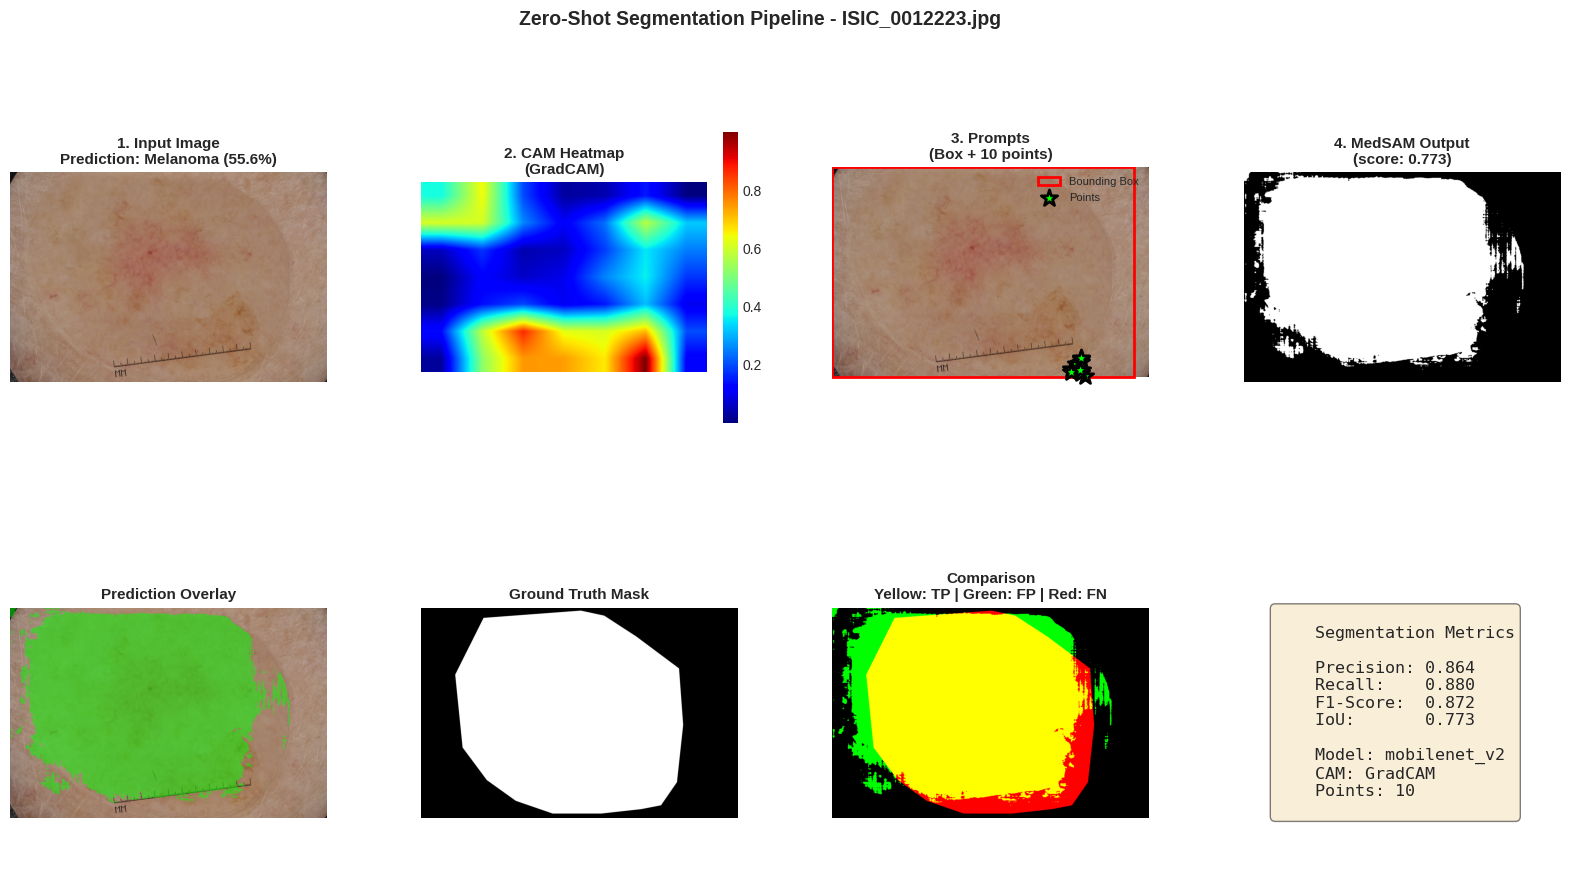

   IoU: 0.773, F1: 0.872

Processing 2/5: ISIC_0014941
   Benign, large lesion, irregular shape
Random seed set to 905
Random seed set to 905


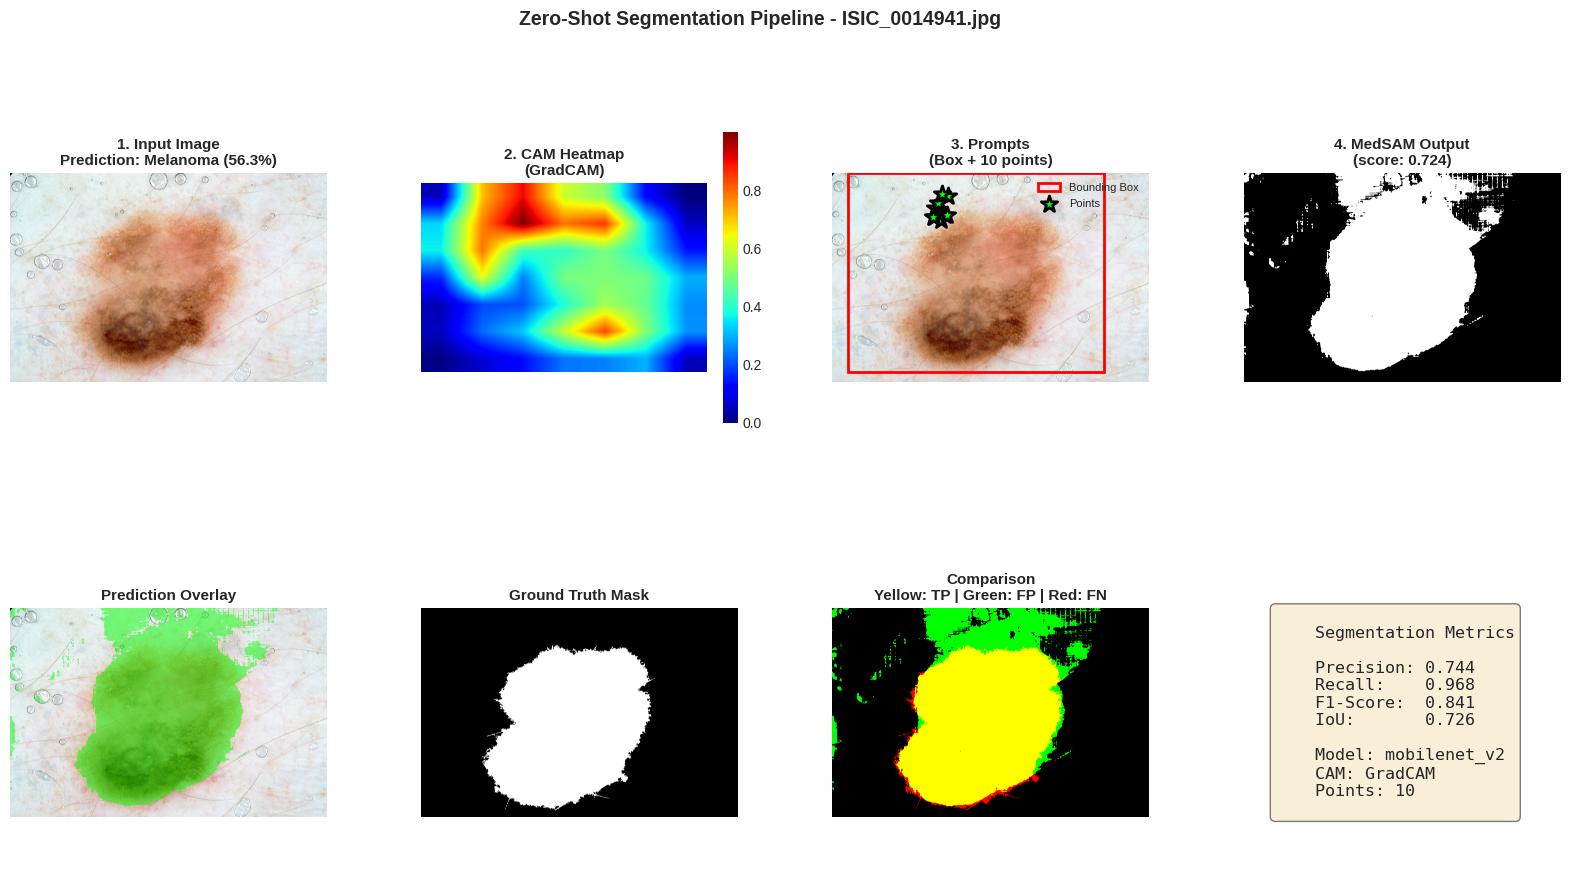

   IoU: 0.726, F1: 0.841

Processing 3/5: ISIC_0015273
   Benign, small lesion, irregular shape
Random seed set to 905
Random seed set to 905


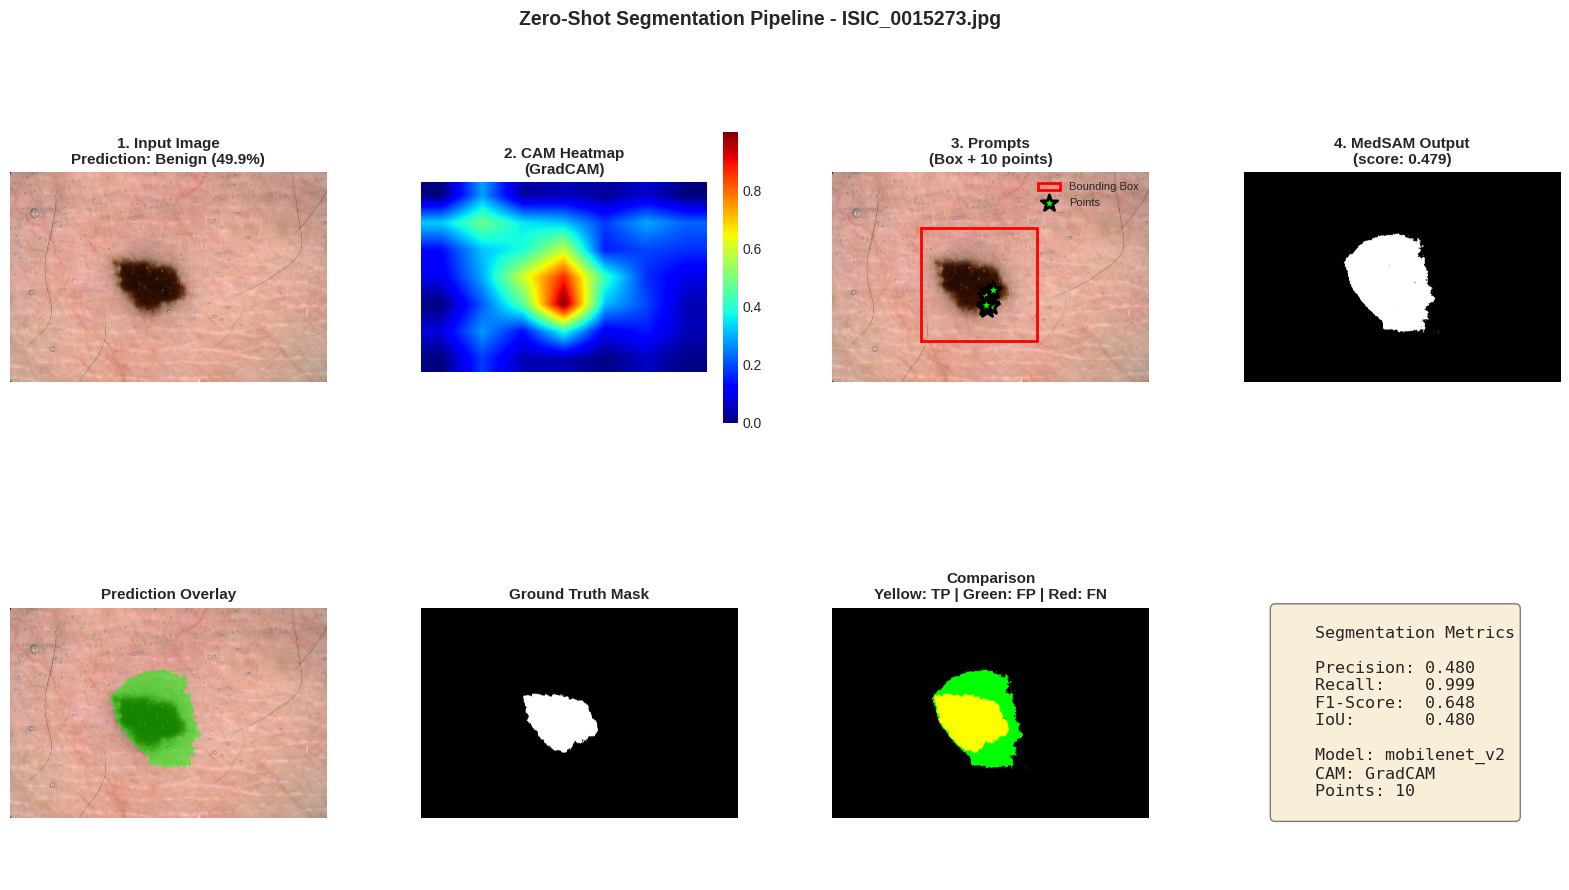

   IoU: 0.480, F1: 0.648

Processing 4/5: ISIC_0016066
   Benign, small lesion, compact/circular
Random seed set to 905
Random seed set to 905


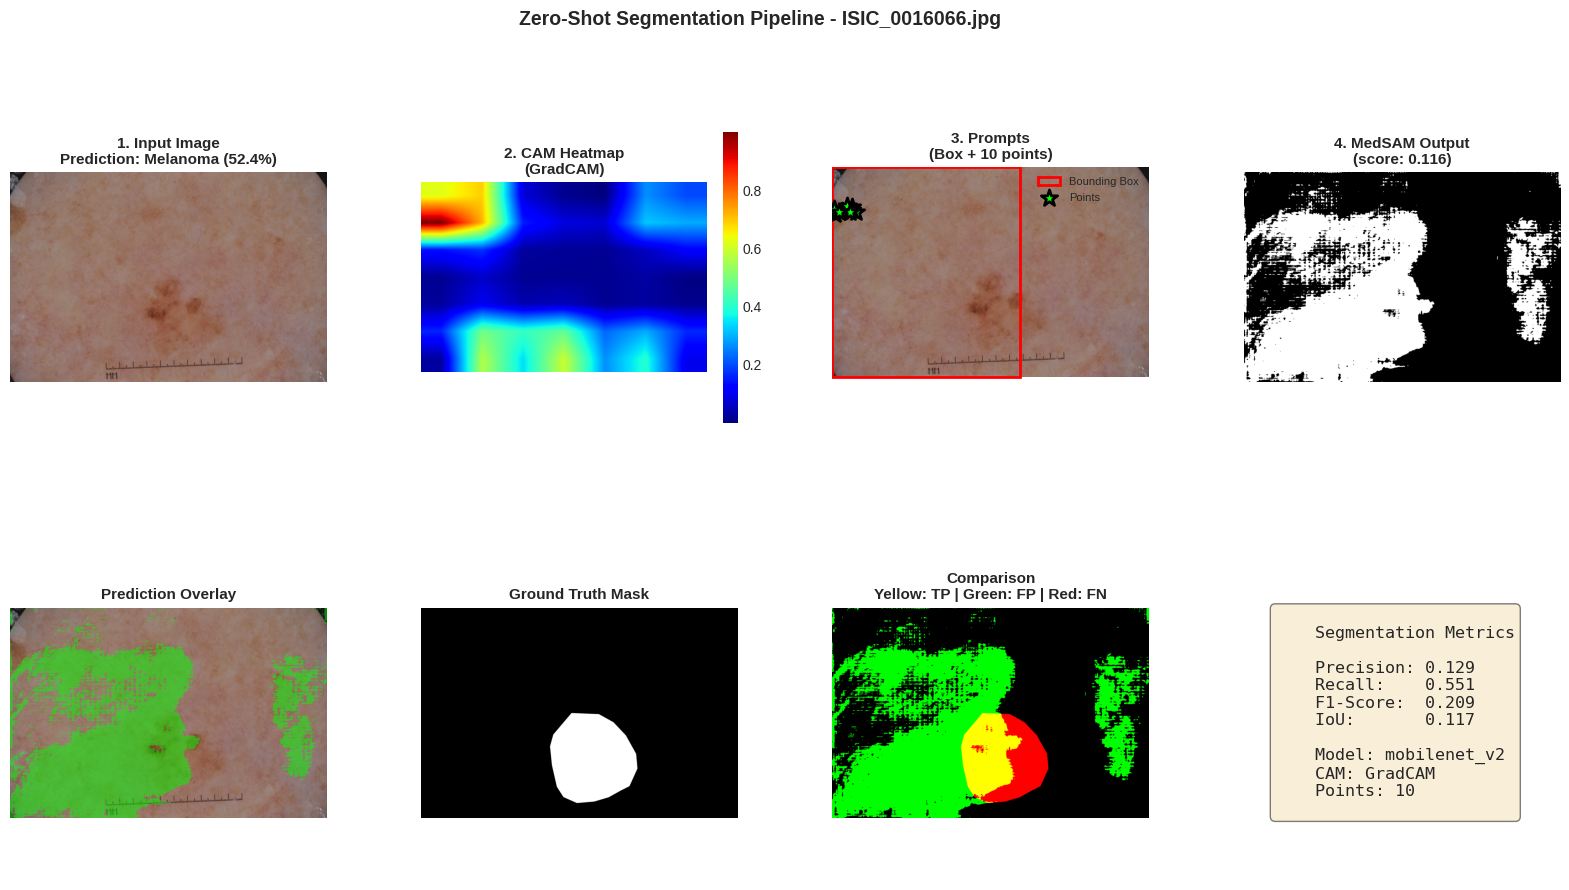

   IoU: 0.117, F1: 0.209

Processing 5/5: ISIC_0016070
   Benign, small lesion, moderate shape
Random seed set to 905
Random seed set to 905


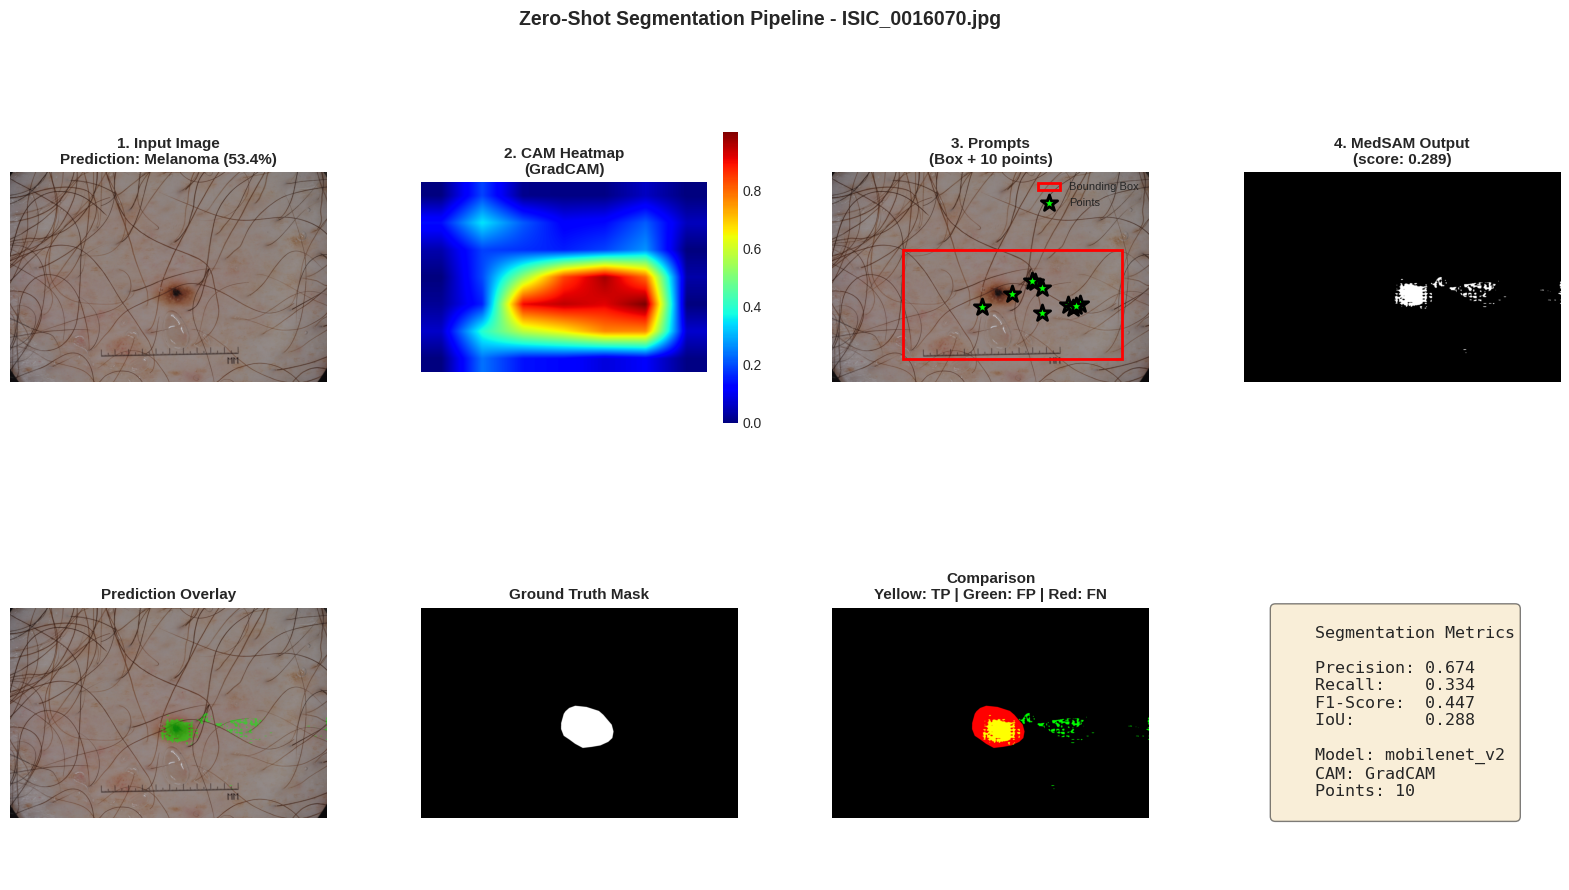

   IoU: 0.288, F1: 0.447



In [14]:
# Process all demo samples
results = []

print("Processing all demo samples...")
print("=" * 60)

for idx, row in demo_info.iterrows():
    print(f"\nProcessing {idx+1}/{len(demo_info)}: {row['image_id']}")
    print(f"   {row['description']}")
    
    # Run pipeline
    precision, recall, f1, iou = visualize_full_pipeline(
        row['image_path'],
        row['mask_path'],
        model,
        cam_methods["GradCAM++"],
        predictor,
        DEVICE,
        num_points=10
    )
    
    results.append({
        'image_id': row['image_id'],
        'label': row['label'],
        'description': row['description'],
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou
    })
    
    print(f"   IoU: {iou:.3f}, F1: {f1:.3f}")

print("\n" + "=" * 60)

In [15]:
# Create summary DataFrame
results_df = pd.DataFrame(results)

print("\nDEMO RESULTS SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Calculate averages
print(f"\nAverage Metrics:")
print(f"   Precision: {results_df['precision'].mean():.3f} ± {results_df['precision'].std():.3f}")
print(f"   Recall:    {results_df['recall'].mean():.3f} ± {results_df['recall'].std():.3f}")
print(f"   F1-Score:  {results_df['f1'].mean():.3f} ± {results_df['f1'].std():.3f}")
print(f"   IoU:       {results_df['iou'].mean():.3f} ± {results_df['iou'].std():.3f}")

# Best and worst
best_idx = results_df['iou'].idxmax()
worst_idx = results_df['iou'].idxmin()

print(f"\nBest Performance:")
print(f"   {results_df.iloc[best_idx]['image_id']}: IoU = {results_df.iloc[best_idx]['iou']:.3f}")
print(f"   {results_df.iloc[best_idx]['description']}")

print(f"\nWorst Performance:")
print(f"   {results_df.iloc[worst_idx]['image_id']}: IoU = {results_df.iloc[worst_idx]['iou']:.3f}")
print(f"   {results_df.iloc[worst_idx]['description']}")


DEMO RESULTS SUMMARY
    image_id  label                            description  precision   recall       f1      iou
ISIC_0012223 Benign Benign, large lesion, compact/circular   0.863635 0.880252 0.871864 0.772836
ISIC_0014941 Benign  Benign, large lesion, irregular shape   0.743777 0.967879 0.841157 0.725860
ISIC_0015273 Benign  Benign, small lesion, irregular shape   0.479859 0.999126 0.648336 0.479658
ISIC_0016066 Benign Benign, small lesion, compact/circular   0.128894 0.550830 0.208905 0.116635
ISIC_0016070 Benign   Benign, small lesion, moderate shape   0.674127 0.334059 0.446740 0.287614

Average Metrics:
   Precision: 0.578 ± 0.287
   Recall:    0.746 ± 0.291
   F1-Score:  0.603 ± 0.279
   IoU:       0.477 ± 0.281

Best Performance:
   ISIC_0012223: IoU = 0.773
   Benign, large lesion, compact/circular

Worst Performance:
   ISIC_0016066: IoU = 0.117
   Benign, small lesion, compact/circular


---
## 8. Conclusion & Next Steps {#conclusion}

### Key Takeaways:

1. **Zero-Shot Learning** - We achieved segmentation without pixel-level annotations during training
2. **CAM Guidance** - Class activation maps effectively localize discriminative regions
3. **Point Prompts** - Probabilistic sampling from CAM peaks provides strong prompts for SAM
4. **MedSAM Integration** - Medical-optimized SAM improves segmentation on dermoscopic images

### Demo Performance:
Based on our diverse demo samples, the pipeline demonstrates:
- Variable performance based on lesion characteristics
- Better results on compact, well-defined lesions
- Challenges with irregular shapes and small lesions

### Limitations:

- Performance depends on classification model quality
- CAM quality varies across architectures
- Point sampling strategy affects results
- Fails on diffuse lesions with unclear boundaries

### Future Work:

- Ensemble CAM methods for robustness
- Adaptive point sampling based on uncertainty
- Extension to multi-class segmentation
- Real-time inference optimization

---

## References

1. **Paper:** Cockayne, M.J.,  Ortolani, M., Al-Bander, B.(2025). "Classification-to-Segmentation: Class Activation Mapping for Zero-Shot Skin Lesion Segmentation" AIIH 2025.
2. **ISIC 2017:** International Skin Imaging Collaboration Challenge
3. **SAM:** Kirillov, A., et al. (2023). "Segment Anything." ICCV 2023.
4. **MedSAM:** Ma, J., et al. (2023). "Segment Anything in Medical Images."
5. **GradCAM:** Selvaraju, R., et al. (2017). "Grad-CAM: Visual Explanations from Deep Networks."

---

## Links

- **GitHub:** https://github.com/xraikeele/Classification-to-Segmentation
- **Paper:** [AIIH 2024 Proceedings](https://doi.org/10.1007/978-3-032-00656-1_24)
- **Author:** Matthew Cockayne (m.j.cockayne@keele.ac.uk)

---

**Thank you for exploring this demo.**